In [38]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import scienceplots             # needed for 'science' style

# ensure inline rendering matches saved figure / uncomment for larger inline figures
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

DATA_DIR = Path("results")
FIG_DIR  = Path("figures")

# physical constants
GC_VAL_4X4 = 2.54
GC_VAL_3X3 = 2.22
GC_LABEL   = r"Critical Point $g_c$"
SUPPORT_LABEL_T = r"Support $g$"

# layout defaults
SINGLE_COL_WIDTH = 3.5
DOUBLE_COL_WIDTH = 7.16
DPI = 150       # dpi is irrelevant for our vectorized output files

# fixed z-order levels
Z_PATCH = -1  # background color
Z_BG    = 0   # support guides
Z_CRIT  = 1   # critical point line
Z_REF   = 2   # ED Reference lines
Z_DATA  = 3   # main data markers/lines

# general plot styles
plt.style.use(["science", "ieee"])
plt.rcParams.update({"mathtext.fontset": "cm", "text.usetex": False})

# hardcoded seaborn-colorblind palette
SB_COLORBLIND = [
    "#0173b2", "#de8f05", "#029e73", "#d55e00", "#cc78bc",
    "#ca9161", "#fbafe4", "#949494", "#ece133", "#56b4e9",
]

# shared styles across figures
STYLE_REF = {"linestyle": "--", "color": "black", "alpha": 0.7, "linewidth": 1.0}
STYLE_SUPP = { "linestyle": (0, (1.5, 2.8)), "linewidth": 0.75, "color": "0.20", "alpha": 0.30}
STYLE_CRIT = { "linestyle": ":", "linewidth": 1.1, "color": "indianred"}

# filter 'alpha' for legend handles so icons are opaque
STYLE_LEGEND = {k: v for k, v in STYLE_SUPP.items() if k != 'alpha'}

STYLE_MARKER_BASE = {
    "support": {"marker": "o", "edge_w": 0.0},
    "novel":   {"marker": "D", "edge_w": 1.2},
}

# vertical lines in the backdrop
def draw_backdrop(ax, support_values, crit_val):
    ax.patch.set_zorder(Z_PATCH)

    for g in sorted(support_values):
        ax.axvline(g, zorder=Z_BG, **STYLE_SUPP)

    ax.axvline(crit_val, zorder=Z_CRIT, **STYLE_CRIT)

In [39]:
report_files = sorted(DATA_DIR.glob("*_report.json"))
if not report_files:
    raise FileNotFoundError(f"No '*_report.json' files found in: {DATA_DIR.resolve()}")

experiments = []
for fpath in report_files:
    with open(fpath, "r") as f:
        experiments.append(json.load(f))
experiments.sort(key=lambda x: x.get("config", {}).get("n_samples", np.inf))

f1_data = []
f1_support_g = set()

for exp in experiments:
    n = exp["config"]["n_samples"]
    df = pd.DataFrame(exp["results"])
    supp = df[df["type"] == "support"]
    nov  = df[df["type"] == "novel"]
    f1_support_g.update(supp["h"].values)

    f1_data.append({"n_samples": n, "df": df, "supp": supp, "nov": nov})

f1_support_g = sorted(f1_support_g)
print(f"Fig 1 data: {len(f1_data)} experiments loaded.")

Fig 1 data: 3 experiments loaded.


Saved: tfim_4x4_data_scaling.pdf


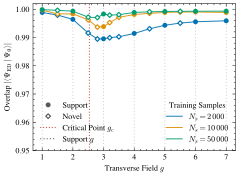

In [40]:
FIG_NAME = "tfim_4x4_data_scaling.pdf"

# local styling overrides
SIZE_SUPP   = 5.0
SIZE_NOV    = 3.3
LEGEND_GREY = "0.35"
YLIM        = (0.95, 1.002)
LINE_ALPHA  = 0.9

# legend handles
h_sem_supp = Line2D([0], [0], linestyle="None", label="Support", marker=STYLE_MARKER_BASE["support"]["marker"],
                    markersize=SIZE_SUPP, markerfacecolor=LEGEND_GREY, markeredgecolor=LEGEND_GREY, markeredgewidth=0.0)

h_sem_nov  = Line2D([0], [0], linestyle="None", label="Novel", marker=STYLE_MARKER_BASE["novel"]["marker"],
                    markersize=SIZE_NOV, markerfacecolor="white", markeredgecolor=LEGEND_GREY,
                    markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"])

h_sem_crit = Line2D([0], [0], label=GC_LABEL, **STYLE_CRIT)
h_sem_guide= Line2D([0], [0], label=SUPPORT_LABEL_T, alpha=1.0, **STYLE_LEGEND)

# figure plotting
width  = SINGLE_COL_WIDTH
height = width * 0.75
fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

for i, item in enumerate(f1_data):
    color = SB_COLORBLIND[i % len(SB_COLORBLIND)]
    n_tex = f"{item['n_samples']:,}".replace(",", r"\,")

    ax.plot(item["df"]["h"], item["df"]["overlap"], color=color, label=rf"$N_s={n_tex}$",
            linestyle="-", linewidth=1.0, alpha=LINE_ALPHA, zorder=Z_DATA)

    ax.plot(item["supp"]["h"], item["supp"]["overlap"], linestyle="None", label="_nolegend_",
            marker=STYLE_MARKER_BASE["support"]["marker"], markersize=SIZE_SUPP,
            color=color, markerfacecolor=color, markeredgewidth=0.0, zorder=Z_DATA)

    ax.plot(item["nov"]["h"], item["nov"]["overlap"], linestyle="None", label="_nolegend_",
            marker=STYLE_MARKER_BASE["novel"]["marker"], markersize=SIZE_NOV, color=color,
            markerfacecolor="white", markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"], zorder=Z_DATA)

draw_backdrop(ax, f1_support_g, GC_VAL_4X4)

ax.set_xlabel(r"Transverse Field $g$")
ax.set_ylabel(r"Overlap $\left|\left\langle \Psi_\mathrm{ED}\mid \Psi_{\mathrm{θ}}\right\rangle\right|$")
if YLIM: ax.set_ylim(YLIM)

ax.yaxis.set_major_locator(mticker.MultipleLocator(0.01))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

# robust legend creation to avoid handle loss. The second legend call detaches the first and we need to re-add it.
leg_samples = ax.legend(loc="lower right", title=r"Training Samples", frameon=False)
leg_semantic = ax.legend(handles=[h_sem_supp, h_sem_nov, h_sem_crit, h_sem_guide], loc="lower left", frameon=False)
ax.add_artist(leg_samples)

ax.grid(False)
fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight")
    print(f"Saved: {FIG_NAME}")
plt.show()

In [41]:
df = pd.read_csv(DATA_DIR / "tfim_4x4_suscept_rbm_mc_20251216_010908.csv")
ref_df = pd.read_csv(DATA_DIR / "tfim_4x4_suscept_ref.csv")

h_eval = df["h"].values
chi_values = df["chi_F"].values
f2_support_lines = [1.00, 1.10, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00]     # would be nice if we had type column

print("Fig 2 data loaded.")

Fig 2 data loaded.


Saved: tfim_4x4_susceptibility_hero.svg


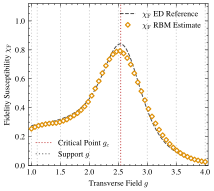

In [42]:
FIG_NAME = "tfim_4x4_susceptibility_hero.svg"

# local Settings
SIZE_NOV   = 3.3
COLOR_MAIN = SB_COLORBLIND[1]
YLIM = (0.0, 1.12)
XLIM = (0.95, 4.05)

h_crit  = Line2D([0], [0], label=GC_LABEL, **STYLE_CRIT)
h_guide = Line2D([0], [0], label=SUPPORT_LABEL_T, alpha=1.0, **STYLE_LEGEND)

width  = SINGLE_COL_WIDTH * 0.9
height = width * 0.9
fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)


ax.plot(ref_df["h"].values, ref_df["chi_F"].values, zorder=Z_REF, label=r"$\chi_\mathrm{F}$ ED Reference", **STYLE_REF)

ax.plot(h_eval, chi_values, linestyle="None", label=r"$\chi_\mathrm{F}$ RBM Estimate",
        marker=STYLE_MARKER_BASE["novel"]["marker"], markersize=SIZE_NOV, color=COLOR_MAIN,
        markerfacecolor="white", markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"], zorder=Z_DATA)

draw_backdrop(ax, f2_support_lines, GC_VAL_4X4)

# decoration
ax.set_xlabel(r"Transverse Field $g$")
ax.set_ylabel(r"Fidelity Susceptibility $\chi_\mathrm{F}$")
if XLIM: ax.set_xlim(*XLIM)
if YLIM: ax.set_ylim(*YLIM)

leg_main = ax.legend(loc="upper right", frameon=False)
leg_guides = ax.legend(handles=[h_crit, h_guide], loc="lower left", frameon=False)
ax.add_artist(leg_main)

ax.grid(False)
fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight") # text is converted to paths in SVG
    print(f"Saved: {FIG_NAME}")
plt.show()

In [43]:
df_s = pd.read_csv(DATA_DIR / "tfim_3x3_suscept_rbm_mc_20251217_142434.csv")
f3_ref_df = pd.read_csv(DATA_DIR / "tfim_3x3_suscept_ref.csv")
f3_overlap_df = pd.read_csv(DATA_DIR / "tfim_3x3_overlap_20251217_142126.csv").sort_values("h")

f3_h_eval = df_s["h"].values
f3_chi_val = df_s["chi_F"].values
f3_support_lines = [1.00, 1.40, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00]

print("Fig 3 data loaded.")

Fig 3 data loaded.


Saved: tfim_3x3_susceptibility_with_overlap.pdf


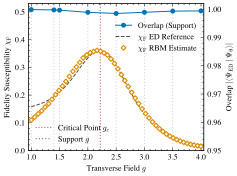

In [44]:
FIG_NAME = "tfim_3x3_susceptibility_with_overlap.pdf"

# local settings
SUSC_YLIM = (0.0, 0.53)
OV_YLIM   = (0.95, 1.002)
XLIM      = (0.95, 4.05)
C_SUSC    = SB_COLORBLIND[1]
C_OV      = SB_COLORBLIND[0]
SZ_SUSC   = 3.3
SZ_OV     = 5.0

h_crit  = Line2D([0], [0], label=GC_LABEL, **STYLE_CRIT)
h_guide = Line2D([0], [0], label=SUPPORT_LABEL_T, alpha=1.0, **STYLE_LEGEND)

width  = SINGLE_COL_WIDTH
height = width * 0.75
fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

ax.plot(f3_ref_df["h"], f3_ref_df["chi_F"], zorder=Z_REF, label=r"$\chi_\mathrm{F}$ ED Reference", **STYLE_REF)

ax.plot(f3_h_eval, f3_chi_val, linestyle="None", label=r"$\chi_\mathrm{F}$ RBM Estimate",
        marker=STYLE_MARKER_BASE["novel"]["marker"], markersize=SZ_SUSC, color=C_SUSC, markerfacecolor="white",
        markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"], zorder=Z_DATA)

ax2 = ax.twinx()
ax2.plot(f3_overlap_df["h"], f3_overlap_df["overlap"], linestyle="-", linewidth=1.0,
         marker=STYLE_MARKER_BASE["support"]["marker"], markersize=SZ_OV, color=C_OV,
         markerfacecolor=C_OV, markeredgewidth=0.0, label="Overlap (Support)", zorder=Z_DATA)

draw_backdrop(ax, f3_support_lines, GC_VAL_3X3)

ax.set_xlabel(r"Transverse Field $g$")
ax.set_ylabel(r"Fidelity Susceptibility $\chi_\mathrm{F}$")
ax.set_ylim(SUSC_YLIM)
ax.set_xlim(XLIM)

ax2.set_ylabel(r"Overlap $\left|\left\langle \Psi_\mathrm{ED}\mid \Psi_{\mathrm{θ}}\right\rangle\right|$")
ax2.set_ylim(OV_YLIM)
ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.01))
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

# combine left and right axis entries into main legend
h1, l1 = ax.get_legend_handles_labels()   # susc
h2, l2 = ax2.get_legend_handles_labels()  # overlap

# right side anchoring for main legend
leg_main = ax.legend(h2 + h1, l2 + l1, loc="center right", bbox_to_anchor=(1.00, 0.77),
                     bbox_transform=ax2.transAxes, frameon=False)
leg_guides = ax.legend(handles=[h_crit, h_guide], loc="lower left", frameon=False)
ax.add_artist(leg_main)

ax.grid(False)
fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight")
    print(f"Saved: {FIG_NAME}")
plt.show()

In [45]:
SIDE_LENGTH = 4
base = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnetizations"

df_full  = pd.read_csv(DATA_DIR / f"{base}_full.csv")
df_three = pd.read_csv(DATA_DIR / f"{base}_two_point.csv")
df_one   = pd.read_csv(DATA_DIR / f"{base}_one_point.csv")
ref_df   = pd.read_csv(DATA_DIR / f"{base}_ref.csv")

print("Fig 4 data loaded.")

Fig 4 data loaded.


Saved: tfim_4x4_magnetization.pdf


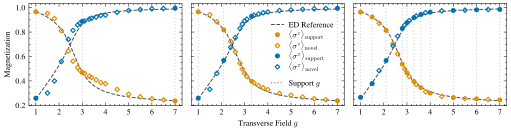

In [46]:
FIG_NAME = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnetization.pdf"

# local settings
SIZE_SUPP = 5.1
SIZE_NOV  = 3.2
COLOR_Z   = SB_COLORBLIND[1]
COLOR_X   = SB_COLORBLIND[0]
FIG_MARGINS = {'left': 0.055, 'right': 0.985, 'bottom': 0.30, 'top': 0.92, 'wspace': 0.06}

h_ref = Line2D([0], [0], label="ED Reference", **STYLE_REF)

def mk_h(c, type_key, sz):
    base = STYLE_MARKER_BASE[type_key]
    return Line2D([0], [0], linestyle="None", color=c, marker=base["marker"], markersize=sz,
                  markerfacecolor=c if type_key == "support" else "none", markeredgewidth=base["edge_w"])

h_z_supp = mk_h(COLOR_Z, "support", SIZE_SUPP)
h_z_nov  = mk_h(COLOR_Z, "novel",   SIZE_NOV)
h_x_supp = mk_h(COLOR_X, "support", SIZE_SUPP)
h_x_nov  = mk_h(COLOR_X, "novel",   SIZE_NOV)

h_spacer = Line2D([0], [0], linestyle="None", marker=None, alpha=0)
h_guide  = Line2D([0], [0], label=SUPPORT_LABEL_T, alpha=1.0, **STYLE_LEGEND)

LEGEND_HANDLES = [h_ref, h_z_supp, h_z_nov, h_x_supp, h_x_nov, h_spacer, h_guide]
LEGEND_LABELS  = [
    "ED Reference",
    r'$\langle \sigma^z \rangle_{\mathrm{support}}$', r'$\langle \sigma^z \rangle_{\mathrm{novel}}$',
    r'$\langle \sigma^x \rangle_{\mathrm{support}}$', r'$\langle \sigma^x \rangle_{\mathrm{novel}}$',
    " ", SUPPORT_LABEL_T
]

def _plot_panel(ax, df, ref_df):
    if df is None: return

    # ensure background doesn't hide lines
    ax.patch.set_zorder(Z_PATCH)

    support_g = np.unique(df[df["type"] == "support"]["h"].to_numpy())
    for g0 in support_g:
        ax.axvline(g0, zorder=Z_BG, **STYLE_SUPP)

    ax.plot(ref_df["h"], ref_df["mag_z"], zorder=Z_REF, **STYLE_REF)
    ax.plot(ref_df["h"], ref_df["mag_x"], zorder=Z_REF, **STYLE_REF)

    for type_key, sub_df in df.groupby("type"):
        if type_key not in ["support", "novel"]: continue

        # determine styling based on type
        sz = SIZE_SUPP if type_key == "support" else SIZE_NOV
        base = STYLE_MARKER_BASE[type_key]
        fc_z = COLOR_Z if type_key == "support" else "none"
        fc_x = COLOR_X if type_key == "support" else "none"

        ax.plot(sub_df["h"], sub_df["mz"], linestyle="None", zorder=Z_DATA, color=COLOR_Z,
                marker=base["marker"], markersize=sz, markeredgewidth=base["edge_w"], markerfacecolor=fc_z)
        ax.plot(sub_df["h"], sub_df["mx"], linestyle="None", zorder=Z_DATA, color=COLOR_X,
                marker=base["marker"], markersize=sz, markeredgewidth=base["edge_w"], markerfacecolor=fc_x)

# actual plotting
width  = DOUBLE_COL_WIDTH
height = width * 0.32
fig, axes = plt.subplots(1, 3, figsize=(width, height), dpi=DPI, sharey=True,
                         gridspec_kw={"wspace": 0.06}, constrained_layout=False)

_plot_panel(axes[0], df_one,   ref_df)
_plot_panel(axes[1], df_three, ref_df)
_plot_panel(axes[2], df_full,  ref_df)

axes[0].set_ylabel("Magnetization")
axes[1].set_xlabel(r"Transverse Field $g$")

for ax in axes:
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1.0))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%d"))
    ax.grid(False)

# centralized legend on middle panel
axes[1].legend(
    LEGEND_HANDLES, LEGEND_LABELS, loc="center right", bbox_to_anchor=(0.95, 0.50),
    frameon=False, handlelength=1.6, handletextpad=0.6, labelspacing=0.08, borderaxespad=0.0
)

# manual Margins for precise PDF sizing
fig.subplots_adjust(**FIG_MARGINS)
fig.set_size_inches(width, height, forward=True)

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME)
    print(f"Saved: {FIG_NAME}")
plt.show()